<a href="https://colab.research.google.com/github/FrancescoTorella/progettoLabAI/blob/main/prova_progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#importo i moduli
import os
import numpy as np
!pip install rasterio
import rasterio
import torch
from torch.utils.data import Dataset,DataLoader,Subset
from torchvision import transforms
import albumentations as A
from sklearn.model_selection import train_test_split


In [ ]:
# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
class MultispectralDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory con tutte le immagini.
            transform (callable, optional): Trasformazioni da applicare ai campioni.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.tif')]

    def __len__(self):
        """Restituisce il numero totale di campioni nel dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Indice del campione da restituire.

        Returns:
            dict: Campione contenente l'immagine e, se applicabile, l'etichetta.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_files[idx]
        with rasterio.open(img_name) as src:
            image = src.read()  # Leggi l'immagine multispettrale
        image = np.moveaxis(image, 0, -1)  # Converti da (bands, H, W) a (H, W, bands)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return {'image': image}


# Percorso alla directory del dataset
data_dir = '/content/drive/My Drive/LabAi3/train/PS-RGBNIR'

# Definisci le trasformazioni da applicare alle immagini
transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.pytorch.ToTensorV2()
])

# Crea un'istanza del dataset
dataset = MultispectralDataset(data_dir=data_dir, transform=transform)

# Suddividi il dataset in train, validation e test set
train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Crea i DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Esempio di utilizzo del DataLoader
for batch in train_loader:
    images = batch['image']
    print(images.shape)
    break

Provo ad aprire un'immagine a caso separatamente sui 4 canali, inoltre stampo anche i valori medi la deviazione standard e la varianza tra i pixel

Count of bands: 4
Width: 900, Height: 900


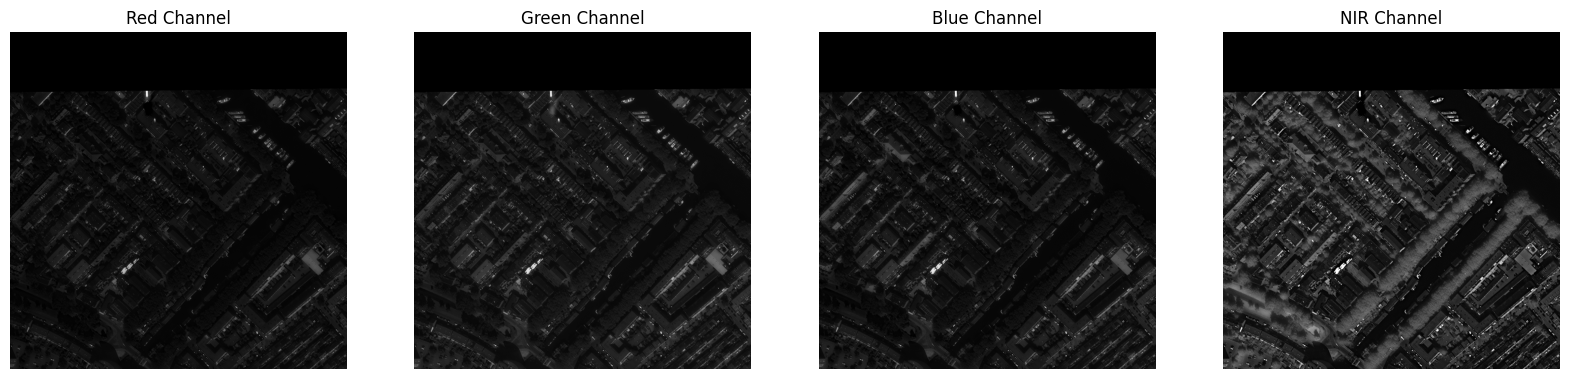

In [16]:

import matplotlib.pyplot as plt
import numpy as np

# Percorso all'immagine TIFF
img_path = '/content/drive/My Drive/progettoLabAi3/train/PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190823162315_20190823162606_tile_7879.tif'

# Apri l'immagine con rasterio
with rasterio.open(img_path) as src:
    # Leggi tutte le bande
    img = src.read()
    # Ottieni informazioni sulle dimensioni dell'immagine e numero di bande
    print(f"Count of bands: {src.count}")
    print(f"Width: {src.width}, Height: {src.height}")

# Assumiamo che i canali siano organizzati come [R, G, B, NIR]
R = img[0]
G = img[1]
B = img[2]
NIR = img[3]

# Funzione per normalizzare i valori dei pixel
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Normalizza ciascun canale
R_normalized = normalize(R)
G_normalized = normalize(G)
B_normalized = normalize(B)
NIR_normalized = normalize(NIR)

# Visualizza ciascun canale normalizzato
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(R_normalized, cmap='gray')
axs[0].set_title('Red Channel')
axs[0].axis('off')

axs[1].imshow(G_normalized, cmap='gray')
axs[1].set_title('Green Channel')
axs[1].axis('off')

axs[2].imshow(B_normalized, cmap='gray')
axs[2].set_title('Blue Channel')
axs[2].axis('off')

axs[3].imshow(NIR_normalized, cmap='gray')
axs[3].set_title('NIR Channel')
axs[3].axis('off')

plt.show()


Count of bands: 4
Width: 900, Height: 900


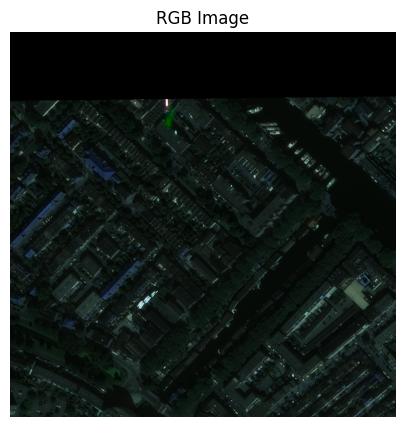

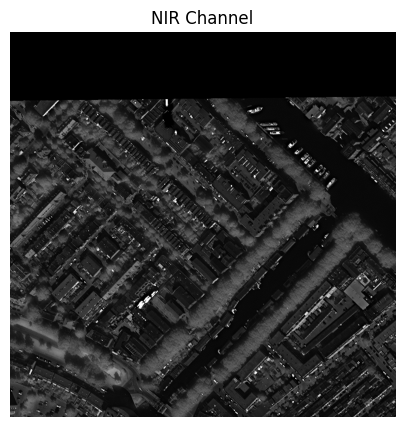

Statistics for Red channel:
  Mean: 91.56096419753086
  Standard Deviation: 96.30445496616233
  Variance: 9274.548046329588

Statistics for Green channel:
  Mean: 120.41924074074075
  Standard Deviation: 109.61429755537974
  Variance: 12015.294228559327

Statistics for Blue channel:
  Mean: 132.1670135802469
  Standard Deviation: 136.58222980249676
  Variance: 18654.70549782203

Statistics for NIR channel:
  Mean: 279.99204567901234
  Standard Deviation: 270.2708258595493
  Variance: 73046.31931080282



In [17]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Percorso all'immagine TIFF
img_path = '/content/drive/My Drive/progettoLabAi3/train/PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190823162315_20190823162606_tile_7879.tif'

# Apri l'immagine con rasterio
with rasterio.open(img_path) as src:
    # Leggi tutte le bande
    img = src.read()
    # Ottieni informazioni sulle dimensioni dell'immagine e numero di bande
    print(f"Count of bands: {src.count}")
    print(f"Width: {src.width}, Height: {src.height}")

# Assumiamo che i canali siano organizzati come [R, G, B, NIR]
R = img[0]
G = img[1]
B = img[2]
NIR = img[3]

# Funzione per normalizzare i valori dei pixel
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Normalizza i canali RGB
R_normalized = normalize(R)
G_normalized = normalize(G)
B_normalized = normalize(B)
NIR_normalized = normalize(NIR)

# Combina i canali R, G e B per creare un'immagine a colori
rgb_normalized = np.dstack((R_normalized, G_normalized, B_normalized))

# Visualizza l'immagine combinata RGB
plt.figure(figsize=(10, 5))
plt.imshow(rgb_normalized)
plt.title('RGB Image')
plt.axis('off')
plt.show()

# Visualizza il canale NIR normalizzato
plt.figure(figsize=(10, 5))
plt.imshow(NIR_normalized, cmap='gray')
plt.title('NIR Channel')
plt.axis('off')
plt.show()

# Calcola le statistiche per ogni canale
channels = {'Red': R, 'Green': G, 'Blue': B, 'NIR': NIR}
statistics = {}

for name, channel in channels.items():
    mean_val = np.mean(channel)
    std_val = np.std(channel)
    var_val = np.var(channel)
    statistics[name] = {
        'mean': mean_val,
        'std': std_val,
        'var': var_val
    }

# Stampa le statistiche
for channel, stats in statistics.items():
    print(f"Statistics for {channel} channel:")
    print(f"  Mean: {stats['mean']}")
    print(f"  Standard Deviation: {stats['std']}")
    print(f"  Variance: {stats['var']}")
    print()


In [4]:
# Monta Google Drive (opzionale)

# Clona il repository GitHub
!git clone https://github.com/FrancescoTorella/progettoLabAI.git

# Naviga nella directory del repository
%cd progettoLabAI

# Crea una nuova directory per i notebook di Colab (opzionale)
!mkdir colab_notebooks
%cd colab_notebooks

# Crea un nuovo file di esempio
with open('example_notebook.ipynb', 'w') as f:
    f.write('# Nuovo notebook di esempio')

# Configura git per il push delle modifiche
!git config --global user.email "torella.1984820@studenti.uniroma1.it"
!git config --global user.name "FrancescoTorella"

# Aggiungi, commit e push delle modifiche
!git add example_notebook.ipynb
!git commit -m "Aggiungi nuovo notebook di esempio"
!git push origin main


Cloning into 'progettoLabAI'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.
/content/colab_notebooks/progettoLabAI/colab_notebooks/progettoLabAI
/content/colab_notebooks/progettoLabAI/colab_notebooks/progettoLabAI/colab_notebooks
[main 972c957] Aggiungi nuovo notebook di esempio
 1 file changed, 1 insertion(+)
 create mode 100644 colab_notebooks/example_notebook.ipynb
fatal: could not read Username for 'https://github.com': No such device or address
